# Benchmarking the Recovery of Known Drug Targets from L1000 Chemical Perturbation Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import requests
import scipy.stats as ss
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.dge.limma_voom import limma_voom_differential_expression
from maayanlab_bioinformatics.enrichment import enrich_crisp
from math import log2
from IPython.display import display, Markdown
from random import sample
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import seaborn as sns
from os.path import exists
from scipy.stats import ttest_ind, ranksums
import h5py

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# Set perturbagen
pert = 'dexamethasone'

# Set working directory
l1000_data_dir = '../L1000_data'

In [4]:
try: 
    expr_df = pd.read_csv(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_fulldata.tsv", sep='\t', index_col=0)
except: 
    l1000_data_df = pd.read_csv(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_data.tsv", sep='\t')

    l1000_data_list = []
    l1000_meta_list = []
    for row in l1000_data_df.itertuples(): 
        try:
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns:
            l1000_meta_list.append([col] + l1000_data_df.loc[row.Index].tolist())
        l1000_data_list.append(temp_df)
    expr_df = pd.concat(l1000_data_list, axis=1)
expr_df.head()

,CPC004_A375_6H_X1_B3_DUO52HI53LO:E13,CPC004_A375_6H_X2_B3_DUO52HI53LO:E13,CPC004_A375_6H_X3_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X1_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X2_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X3_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X1_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X2_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X3_B3_DUO52HI53LO:E13,CPC004_HCC515_24H_X1_B3_DUO52HI53LO:E13,...,CRCGN004_PC3_6H_X2_F1B7_DUO52HI53LO:J21,LPROT002_A375_6H_X1_B22:H07,LPROT002_A375_6H_X1_B22:H09,LPROT002_A375_6H_X1_B22:H11,LPROT002_MCF7_6H_X1_B22:H08,LPROT002_MCF7_6H_X1_B22:H10,LPROT002_MCF7_6H_X1_B22:H12,LPROT004_YAPC_6H_X1_B32:H07,LPROT004_YAPC_6H_X1_B32:H09,LPROT004_YAPC_6H_X1_B32:H11
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,5.347525,5.31260,5.54900,5.2620,5.3664,5.1632,6.5029,6.1924,5.701800,5.69435,...,6.521600,3.8543,4.558200,4.8785,4.0917,4.3097,4.594400,5.051500,4.67150,5.2628
ADA,6.814449,6.21185,7.37235,7.9995,7.4117,7.6526,8.4221,7.4373,9.558400,7.31210,...,8.412251,8.5299,8.172900,7.8001,7.7042,7.5313,7.161799,6.563300,5.72615,6.8200
CDH2,7.497050,8.35885,7.51460,10.1442,11.5089,10.4157,9.9937,6.0723,7.950950,6.61335,...,3.211200,10.5305,9.309799,9.0100,5.4028,5.9991,5.022750,6.782700,6.52530,6.6286
AKT3,9.710200,11.61895,9.40310,10.4081,9.9464,9.1548,10.6656,9.7118,8.052999,7.07675,...,7.751399,9.9655,8.703700,9.5298,5.4086,7.9250,5.372250,8.076001,7.89250,8.1305
MED6,7.923500,6.12090,8.32925,8.2268,7.8020,8.0996,8.9311,8.5562,9.422951,8.44575,...,9.265400,9.7446,9.507300,9.4560,10.4112,9.0910,9.762300,9.515800,9.54300,9.8093


In [5]:
if not exists(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_fulldata.tsv"): 
    expr_df.to_csv(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_fulldata.tsv' already exists!")

File at '../L1000_data/Dexamethasone_L1000_ChemPert_fulldata.tsv' already exists!


In [6]:
try: 
    meta_df = pd.read_csv(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_metadata.tsv", sep='\t', index_col=0)
except:
    meta_df = pd.DataFrame(l1000_meta_list, columns=['id'] + l1000_data_df.columns.tolist()).set_index('id')
if 'batch' not in meta_df.columns:
    meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
CPC004_A375_6H_X1_B3_DUO52HI53LO:E13,skin of body,melanoma,A375,dexamethasone,6 h,Chemical Perturbation,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,CPC004_A375_6H
CPC004_A375_6H_X2_B3_DUO52HI53LO:E13,skin of body,melanoma,A375,dexamethasone,6 h,Chemical Perturbation,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,CPC004_A375_6H
CPC004_A375_6H_X3_B3_DUO52HI53LO:E13,skin of body,melanoma,A375,dexamethasone,6 h,Chemical Perturbation,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,CPC004_A375_6H
CPC004_HA1E_24H_X1_B3_DUO52HI53LO:E13,kidney,NaN,HA1E,dexamethasone,24 h,Chemical Perturbation,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,CPC004_HA1E_24H
CPC004_HA1E_24H_X2_B3_DUO52HI53LO:E13,kidney,NaN,HA1E,dexamethasone,24 h,Chemical Perturbation,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,CPC004_HA1E_24H


In [7]:
if not exists(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_metadata.tsv"): 
    meta_df.to_csv(f"{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{pert.capitalize()}_L1000_ChemPert_metadata.tsv' already exists!")

File at '../L1000_data/Dexamethasone_L1000_ChemPert_metadata.tsv' already exists!


In [8]:
all_batches = set(['_'.join(x.split('_')[:3]) for x in meta_df.index.tolist()])
len(all_batches)

240

## Load in MODZ Data

In [9]:
modz_data_df = pd.read_csv('/Users/maayanlab/Downloads/dex_modz.gct', sep='\t', header=2).iloc[8:].set_index('pr_gene_symbol')
modz_data_df = modz_data_df.drop(columns=['id', 'pr_gene_title', 'pr_is_lm', 'pr_is_bing', 'self_correlation', 'frac_self_rank', 'p_value', 'gene_space'])
modz_data_df = modz_data_df.astype('float32')
modz_data_df.loc['MIA2'] = modz_data_df.loc[['MIA2', 'CTAGE5']].mean(axis=0)
modz_data_df = modz_data_df.drop(index=['CTAGE5'])
modz_data_df.columns = modz_data_df.columns.map(lambda x: x.split(':')[0])
modz_data_df = modz_data_df[[x for x in modz_data_df.columns if x.endswith('24H') ]]
modz_data_df

,CPC006_A375_24H,CPC006_A549_24H,CPC006_HA1E_24H,CPC006_HCC515_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_PC3_24H,CPC009_A549_24H,CPC009_MCF7_24H,CPC009_PC3_24H,CPC006_VCAP_24H,CPC009_VCAP_24H,CRCGN001_HA1E_24H,CRCGN004_HA1E_24H
pr_gene_symbol,,,,,,,,,,,,,,
PSME1,0.50,-1.32,1.37,1.03,0.67,0.47,-0.17,-0.44,1.65,0.07,0.24,0.27,-0.58,0.72
ATF1,1.03,-0.42,0.98,0.26,0.39,0.76,0.09,-0.05,-1.87,0.65,0.10,0.53,-0.78,-0.02
RHEB,-0.02,-0.66,-0.27,-0.84,0.41,0.04,0.24,-0.63,1.13,1.06,0.41,-0.48,-0.76,0.05
FOXO3,-0.75,2.80,-1.63,1.05,-0.16,-0.67,-0.94,1.96,-0.21,-0.31,-0.54,0.37,-0.24,0.20
RHOA,0.10,-0.33,-0.37,1.16,-0.11,1.08,0.85,0.02,1.40,0.34,0.35,0.43,-0.45,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADGRA2,-0.34,0.24,0.05,-1.21,-0.34,-0.34,-0.16,-0.26,-0.29,-0.25,-0.17,-1.03,0.70,-0.40
CX3CL1,-0.33,-0.18,-0.17,0.21,-0.21,-0.41,0.33,0.07,-0.44,0.38,-0.20,-0.90,0.18,-0.12
ADAP1,-0.48,-0.09,-0.99,0.23,-0.06,-0.54,0.42,-0.43,-0.65,0.53,-0.49,1.17,1.23,0.12


## Load in Control Data

In [10]:
gctx = h5py.File(f"{l1000_data_dir}/Dexamethasone_L1000_Controls_fulldata.gctx", 'r')
ctrl_expr_df = pd.DataFrame(
    data=gctx['0/DATA/0/matrix'][()],
    index=gctx['0/META/COL/id'].asstr()[:],
    columns=gctx['0/META/ROW/id'].asstr()[:]
).T
gctx.close()

In [11]:
overlapping_dex = set(expr_df.columns.tolist()).intersection(ctrl_expr_df.columns.tolist())

In [12]:
ctrl_expr_df = ctrl_expr_df.drop(columns=list(overlapping_dex))
ctrl_expr_df.head()

,CPC006_A375_24H_X5_B4_DUO52HI53LO:A17,CPC006_A375_24H_X1_B3_DUO52HI53LO:A18,CPC006_A375_24H_X2_B3_DUO52HI53LO:A18,CPC006_A375_24H_X5_B4_DUO52HI53LO:A18,CPC006_A375_24H_X2_B3_DUO52HI53LO:B17,CPC006_A375_24H_X4_B4_DUO52HI53LO:B17,CPC006_A375_24H_X5_B4_DUO52HI53LO:B17,CPC006_A375_24H_X1_B3_DUO52HI53LO:B18,CPC006_A375_24H_X4_B4_DUO52HI53LO:B18,CPC006_A375_24H_X5_B4_DUO52HI53LO:B18,...,CPC009_PC3_24H_X1_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X2_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X3_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X4_B5_DUO52HI53LO:L12,CPC009_PC3_24H_X5_F1B5_DUO52HI53LO:L12,CPC009_PC3_24H_X1_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X2_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X3_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X4_B5_DUO52HI53LO:L13,CPC009_PC3_24H_X5_F1B5_DUO52HI53LO:L13
NAT2,7.89775,8.68995,6.80705,8.04730,7.54740,6.815075,7.633851,7.339425,8.56575,7.03535,...,4.59600,5.69120,5.410600,5.16645,5.6062,5.12355,5.612900,5.61780,5.964099,5.46440
ADA,3.51090,4.02850,4.11730,3.89205,4.56435,4.913550,4.724325,3.815050,3.26435,3.49990,...,9.13180,9.69640,10.277700,8.01760,9.1136,8.69590,9.973300,9.98530,8.143050,8.43330
CDH2,5.07510,5.84900,5.84390,5.05145,5.76565,5.012725,4.946300,6.192550,4.91245,4.96025,...,4.98080,3.02930,3.250800,4.04120,3.6938,5.21580,3.833500,3.92415,3.731000,6.07040
AKT3,3.64940,4.85665,4.31915,5.40425,5.03620,3.253500,4.558100,4.819650,6.11925,4.10250,...,5.80955,6.67030,7.958799,5.72470,5.8401,6.77600,7.432001,8.05450,5.867200,6.17385
MED6,5.20905,5.51090,6.04015,5.06230,5.91720,4.498100,5.335800,5.388175,5.42000,5.15100,...,8.67330,7.03495,8.061700,8.36450,8.3464,8.82380,7.499700,8.43520,8.015600,9.17250


In [13]:
# ctrl_expr_df.to_csv('../L1000_data/Dexamethasone_L1000_Control_Profiles.tsv.gz', sep='\t')

In [14]:
ctrl_meta_df = pd.DataFrame(
  data = [ctrl_expr_df.columns.tolist(),['_'.join(x.split('_')[:3]) for x in ctrl_expr_df.columns]],
  index = ['id', 'batch']
).T.set_index('id')
ctrl_meta_df.head()

,batch
id,
CPC006_A375_24H_X5_B4_DUO52HI53LO:A17,CPC006_A375_24H
CPC006_A375_24H_X1_B3_DUO52HI53LO:A18,CPC006_A375_24H
CPC006_A375_24H_X2_B3_DUO52HI53LO:A18,CPC006_A375_24H
CPC006_A375_24H_X5_B4_DUO52HI53LO:A18,CPC006_A375_24H
CPC006_A375_24H_X2_B3_DUO52HI53LO:B17,CPC006_A375_24H


## Process Data

### Remove duplicate genes

In [15]:
combined_expr_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_expr_df.head()

,CPC004_A375_6H_X1_B3_DUO52HI53LO:E13,CPC004_A375_6H_X2_B3_DUO52HI53LO:E13,CPC004_A375_6H_X3_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X1_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X2_B3_DUO52HI53LO:E13,CPC004_HA1E_24H_X3_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X1_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X2_B3_DUO52HI53LO:E13,CPC004_HA1E_6H_X3_B3_DUO52HI53LO:E13,CPC004_HCC515_24H_X1_B3_DUO52HI53LO:E13,...,CPC009_PC3_24H_X1_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X2_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X3_F1B4_DUO52HI53LO:L12,CPC009_PC3_24H_X4_B5_DUO52HI53LO:L12,CPC009_PC3_24H_X5_F1B5_DUO52HI53LO:L12,CPC009_PC3_24H_X1_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X2_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X3_F1B4_DUO52HI53LO:L13,CPC009_PC3_24H_X4_B5_DUO52HI53LO:L13,CPC009_PC3_24H_X5_F1B5_DUO52HI53LO:L13
A1CF,3.706150,5.19435,4.10195,4.64380,4.270800,3.9665,4.4174,4.5412,4.5436,4.50700,...,3.42250,4.26580,3.922100,4.60500,4.60140,3.350000,4.33555,3.6938,4.4059,4.400100
A2M,7.060125,4.31380,7.43550,5.55190,7.082000,6.1772,5.7649,8.5913,6.3916,8.73610,...,8.69920,11.61970,10.921300,8.47680,10.67320,9.651800,8.33980,8.0536,10.0006,9.749900
A4GALT,6.245200,6.80720,6.30480,7.30625,6.827850,7.1949,6.9762,7.0023,6.8364,6.90265,...,6.71325,6.60190,7.314400,6.81515,6.59470,6.657900,6.45930,6.8790,6.4290,6.985100
A4GNT,5.558300,5.77020,5.68940,5.67050,5.731700,5.8950,6.0036,6.2611,6.3069,5.24015,...,5.60620,5.78565,5.702550,6.01230,5.86385,5.448800,6.15945,6.0248,6.0777,5.834650
AAAS,8.256000,6.88010,8.09350,8.25630,8.228301,8.0326,7.9515,7.6869,7.2894,8.11190,...,7.64870,7.58680,7.712349,7.53270,7.52370,7.898301,8.02430,7.7470,7.8282,7.616199


### Get batches

In [16]:
batches = all_batches.intersection(ctrl_meta_df['batch'].unique())
for b in batches:
  print(b)

CPC009_A549_24H
CPC006_A375_24H
CPC006_HA1E_24H
CPC009_MCF7_24H
CPC006_HT29_24H
CPC006_MCF7_24H
CPC006_HCC515_24H
CPC009_PC3_24H
CPC006_A549_24H
CPC006_PC3_24H


## Compute Signatures: Batch Perturbations vs. Batch Controls

In [17]:
batch_profiles = {x: {'perts': [], 'ctrls': []} for x in batches}
for b in batches: 
    batch_profiles[b]['perts'] = meta_df[meta_df['batch'] == b].index.tolist()
    batch_profiles[b]['ctrls'] = ctrl_meta_df[ctrl_meta_df['batch'] == b].index.tolist()

In [18]:
batch_signatures = {
    'cd': {}, 
    'limma': {}, 
    'limma-voom': {},
    'fc': {},
    'ranksum': {},
    'ttest': {},
    'modz': {},
}

### MODZ

In [19]:
for b in batches: 
  batch_signatures['modz'][b] = pd.concat([
    modz_data_df[b].rename('MODZ'), 
    modz_data_df[b].apply(abs).rename('Significance')
  ], axis=1)

### Characteristic Direction

In [20]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset):
  
    signature = characteristic_direction(
        dataset.loc[:, ctrl_ids], 
        dataset.loc[:, case_ids], 
        calculate_sig=True
    )
    signature['Significance'] = signature['CD-coefficient'].apply(abs)
    
    return signature.sort_values(by=['CD-coefficient'], ascending=False)

Note: the following step may take a few minutes to run.

In [21]:
for b in batches: 
    batch_signatures['cd'][b] = cd_signature(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

### Limma

In [22]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, voom):
    
    signature = limma_voom_differential_expression(
        dataset.loc[:, ctrl_ids],
        dataset.loc[:, case_ids],
        voom_design=voom,
        filter_genes=False
    )
    signature['Significance'] = signature['P.Value']

    return signature.sort_values("t", ascending=False)

Note: the following step may take a few minutes to run.

In [23]:
for b in batches: 
    batch_signatures['limma'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=False
    )

R[write to console]: Loading required package: R.oo

R[write to console]: Loading required package: R.methodsS3

R[write to console]: R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R[write to console]: R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

R[write to console]: 
Attaching package: ‘R.oo’


R[write to console]: The following object is masked from ‘package:R.methodsS3’:

    throw


R[write to console]: The following objects are masked from ‘package:methods’:

    getClasses, getMethods


R[write to console]: The following objects are masked from ‘package:base’:

    attach, detach, load, save


R[write to console]: R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.

R[write to console]: 
Attaching package: ‘R.utils’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: The following objects are masked from

In [24]:
for b in batches: 
    batch_signatures['limma-voom'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=True
    )

### Wilcoxon Rank-Sum Test

In [25]:
def ranksum(ctrl_ids, case_ids, dataset):
  if len(ctrl_ids) + len(case_ids) < 32: 
    print("Warning! Sample sizes < 16 generally do not provide good results. ")
  res_array = []
  for gene in dataset.index: 
    res = ranksums(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids]
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [26]:
for b in batches: 
    batch_signatures['ranksum'][b] = ranksum(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

### Welch's t-test

In [27]:
def ttest(ctrl_ids, case_ids, dataset):
  res_array = []
  for gene in dataset.index: 
    res = ttest_ind(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids],
      equal_var = False
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [28]:
for b in batches: 
    batch_signatures['ttest'][b] = ttest(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

### (log2) Fold Change

In [29]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset):

    case_mean = dataset.loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset.loc[:, ctrl_ids].mean(axis=1)

    signature = case_mean / (ctrl_mean + 0.001)

    signature_df = pd.DataFrame(
        signature.apply(lambda x: log2(x+0.001)), columns=['logFC']
    )
    signature_df['Significance'] = signature_df['logFC'].apply(abs)
    
    return signature_df.sort_values('logFC', ascending=False)

In [30]:
for b in batches: 
    batch_signatures['fc'][b] = logFC(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

## All Signatures

In [31]:
all_signatures = {}

all_signatures['cd_all']= pd.concat([
    df['CD-coefficient'].rename(b) for (b, df) in batch_signatures['cd'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma-voom_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma-voom'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ranksum_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ranksum'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ttest_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ttest'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['modz_all'] = pd.concat([
    df['MODZ'].rename(b) for (b, df) in batch_signatures['modz'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['fc_all'] = pd.concat([
    df['logFC'].rename(b) for (b, df) in batch_signatures['fc'].items()
], axis=1).sort_index().rename_axis('Gene')

for k in all_signatures.keys(): 
    method = k.split('_')[0].upper()
    display(Markdown(f"All {method} batch signatures"))
    display(all_signatures[k])

All CD batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.005242,0.013102,-0.012737,0.008695,-0.007102,-0.001283,-0.001396,0.018031,0.000952,0.001854
A2M,-0.006546,0.003915,-0.006217,0.022046,-0.009718,-0.000499,0.002863,-0.018333,0.021682,-0.026343
A4GALT,0.000730,0.002384,0.001069,-0.006121,0.000802,0.004756,0.003770,0.003674,0.006834,0.004920
A4GNT,0.000148,-0.002679,-0.001182,-0.004465,-0.004268,0.002543,0.002190,0.006255,-0.001011,0.003500
AAAS,-0.002238,-0.005967,-0.003162,-0.003427,-0.003757,0.008218,0.001099,0.002202,-0.003752,-0.003620
...,...,...,...,...,...,...,...,...,...,...
ZXDB,-0.001844,0.002464,-0.004288,0.000986,-0.004406,-0.000160,0.000702,-0.002293,0.003825,-0.000073
ZXDC,0.000540,0.001144,-0.002195,0.003541,0.008632,0.009406,0.002027,0.000558,0.005625,0.004271
ZYX,-0.005301,-0.013534,-0.002055,-0.003315,-0.006242,0.009712,0.001899,-0.018816,-0.002841,-0.014867


All LIMMA batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.488978,-0.457685,-1.385689,0.224118,-1.803227,-0.496867,-1.345300,-0.066385,-0.294205,-0.823307
A2M,-0.957864,0.199035,-0.675840,0.060950,-1.071238,-1.592196,0.611259,-0.837714,1.287795,-0.226417
A4GALT,1.052068,-0.084085,1.458460,0.837572,-0.671224,1.264702,1.536314,0.306574,0.592904,0.990301
A4GNT,-0.875634,-0.521193,-0.717047,-0.182202,-1.127489,-0.982429,-0.432298,-0.312889,-0.143384,-0.811679
AAAS,-0.698037,1.261981,0.821752,0.469454,-0.123393,1.790793,0.931823,1.166193,0.086139,1.050528
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.583538,-1.103166,-0.708441,1.459864,-1.638648,-1.288176,1.128436,-1.900811,1.740872,-0.855682
ZXDC,-0.366940,0.191507,-0.951470,0.114471,0.964735,-0.582374,-0.111600,-0.705952,0.207162,-0.498437
ZYX,0.680457,0.348942,0.932210,0.061114,0.500599,0.123771,0.036428,0.156431,0.515698,-0.059634


All LIMMA-VOOM batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.530413,-0.432861,-1.057338,0.233817,-1.426047,-0.461192,-1.151080,-0.065431,-0.299872,-0.723968
A2M,-0.985443,0.198667,-0.640593,0.060802,-1.045904,-1.256354,0.612243,-0.857667,1.195174,-0.221229
A4GALT,1.041888,-0.084093,1.457404,0.835355,-0.671289,1.263357,1.541795,0.306185,0.586769,0.992215
A4GNT,-0.803284,-0.518001,-0.693777,-0.182461,-1.089057,-0.957077,-0.420382,-0.310522,-0.146902,-0.778560
AAAS,-0.701899,1.250010,0.816807,0.467396,-0.123432,1.762998,0.924893,1.160633,0.086007,1.044281
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.588070,-1.086361,-0.697761,1.473848,-1.582549,-1.272800,1.158135,-1.859902,1.794068,-0.842987
ZXDC,-0.350736,0.191458,-0.899001,0.114394,0.963724,-0.581834,-0.111469,-0.688386,0.209948,-0.491523
ZYX,0.666952,0.346584,0.894256,0.060987,0.494438,0.123418,0.036396,0.155801,0.511624,-0.059739


All RANKSUM batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.782361,-0.417907,-2.063696,0.782913,-2.412502,0.269830,-1.569126,0.777130,-0.869339,-0.653255
A2M,-1.262522,0.120335,-0.538814,0.079282,-1.368122,-2.055985,1.065474,-1.052777,1.217205,-0.420350
A4GALT,1.383402,-0.227299,1.742911,1.248697,-0.807251,1.710192,1.542712,0.227525,1.838812,1.132939
A4GNT,-0.970396,0.006530,-0.575701,0.052855,-1.996264,-1.091930,0.719418,0.126637,-0.660620,-0.838930
AAAS,-1.302816,1.663231,0.741692,0.670597,-0.350229,2.517042,0.436577,1.034626,0.020807,0.966747
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.849516,-1.035439,-1.143497,1.704571,-1.905869,-1.379944,1.396988,-2.128772,1.862220,-1.568344
ZXDC,-0.530528,0.761498,-1.029542,0.361726,1.300430,-0.254285,0.368019,-0.706636,0.598199,-0.123685
ZYX,1.020763,-0.109141,0.947864,0.044596,0.241755,-0.164244,-0.387013,-0.607014,0.518223,-0.814134


All TTEST batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.600913,-0.815173,-4.637847,0.283788,-3.953539,-2.726108,-2.466058,-0.305456,-0.320777,-3.318610
A2M,-9.727957,0.178960,-0.607508,0.055592,-1.315067,-2.894856,0.621131,-1.619311,1.029799,-0.350408
A4GALT,2.934027,-0.187363,2.333186,2.107487,-1.015374,1.883732,2.554163,0.825312,0.519774,1.478609
A4GNT,-1.084934,-1.452731,-6.601442,-0.197389,-3.900530,-4.730529,-3.498468,-1.255108,-0.246314,-5.220164
AAAS,-1.004628,3.840168,1.741888,0.993238,-0.165691,4.285530,1.795143,1.396759,0.051627,2.359116
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.748831,-1.477842,-0.594905,1.966396,-3.129890,-1.666687,1.818086,-3.603297,1.817554,-1.892693
ZXDC,-2.464852,0.246233,-1.542090,0.161120,1.703616,-1.192863,-0.533967,-1.725556,0.166390,-1.068104
ZYX,13.014875,0.498327,2.174616,0.127387,0.773410,0.128454,-0.150160,0.594875,0.591836,-0.279141


All MODZ batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.34,-0.14,-0.96,1.00,-1.47,0.21,-0.51,0.01,0.44,0.02
A2M,-0.72,-0.19,-0.41,0.18,-0.08,-0.39,0.85,-0.47,1.64,0.39
A4GALT,0.59,-0.13,0.19,1.32,-0.84,0.66,-0.01,-0.31,1.50,0.38
A4GNT,-0.71,-0.61,-1.03,0.75,-1.15,-0.24,0.38,-0.31,0.63,0.04
AAAS,-1.42,0.25,-0.85,0.75,-0.62,0.38,-0.30,0.20,0.12,-0.15
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.10,-0.64,-0.95,1.75,-0.58,-0.30,0.44,-1.07,1.07,-0.42
ZXDC,-0.39,0.10,-0.87,0.83,0.12,0.16,-0.06,-0.58,0.97,-0.12
ZYX,0.65,-0.58,0.19,0.06,0.03,-0.10,-0.07,-0.28,-0.23,-0.39


All FC batch signatures

,CPC009_A549_24H,CPC006_A375_24H,CPC006_HA1E_24H,CPC009_MCF7_24H,CPC006_HT29_24H,CPC006_MCF7_24H,CPC006_HCC515_24H,CPC009_PC3_24H,CPC006_A549_24H,CPC006_PC3_24H
Gene,,,,,,,,,,
A1CF,0.054025,-0.057449,-0.256182,0.025282,-0.184498,-0.090305,-0.134439,-0.033161,-0.039201,-0.158875
A2M,-0.225873,0.017373,-0.086272,0.020151,-0.117227,-0.194216,0.052870,-0.114115,0.202267,-0.024419
A4GALT,0.064774,-0.001729,0.042684,0.049822,-0.013258,0.028068,0.046336,0.013017,0.031620,0.019167
A4GNT,-0.079883,-0.028826,-0.074368,-0.009831,-0.076852,-0.058964,-0.052952,-0.024717,-0.011731,-0.071222
AAAS,-0.046597,0.043787,0.038041,0.029721,-0.003322,0.051654,0.032498,0.040568,0.004224,0.023722
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.023491,-0.019754,-0.014245,0.065967,-0.031598,-0.017098,0.024613,-0.042219,0.045476,-0.016062
ZXDC,-0.043277,0.003964,-0.053541,0.013045,0.028926,-0.028414,-0.009909,-0.036227,0.009077,-0.019981
ZYX,0.065377,0.014156,0.062993,0.007790,0.027131,0.003019,-0.006308,0.007357,0.044630,-0.006935


## Enrichment Analysis Rankings

In [32]:
# Function to get Enrichr Results

def getEnrichrLibrary(library_name): 
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={library_name}'
    resp = requests.get(ENRICHR_URL)
    if not resp.ok: 
        raise Exception(f"Error downloading {library_name} library from Enrichr, please try again.")
    return resp.json()[library_name]['terms']

def getLibraryIter(libdict):
    for k,v in libdict.items():
        if type(v) == list:
            yield k, v
        else:
            yield k, list(v.keys())

def enrich(gene_list, lib_json, name): 
    all_terms = list(lib_json.keys())
    termranks = []
    enrich_res = enrich_crisp(gene_list, getLibraryIter(lib_json), 20000, False)
    enrich_res = [[r[0], r[1].pvalue] for r in enrich_res]
    sorted_res = sorted(enrich_res, key=lambda x: x[1])
    for i in range(len(sorted_res)): 
        termranks.append([name, sorted_res[i][0], i])
    for t in set(all_terms).difference([x[1] for x in termranks]): 
        i+=1
        termranks.append([name, t, i])
    return pd.DataFrame(termranks, columns=['Gene_Set', 'Term', 'Rank'])

In [33]:
chea2022 = getEnrichrLibrary('ChEA_2022')

In [34]:
# Get gene lists to put into Enrichr
gene_lists = {}
for m in all_signatures.keys():
    mname = m.split('_')[0]
    gene_lists[mname] = {'up': {}, 'down': {}, 'combined': {}}
    for col in all_signatures[m].columns: 
        gene_lists[mname]['up'][col] = all_signatures[m][col].sort_values(ascending=False).index.tolist()[:100]
        gene_lists[mname]['down'][col] = all_signatures[m][col].sort_values(ascending=True).index.tolist()[:100]
        gene_lists[mname]['combined'][col] = gene_lists[mname]['up'][col] + gene_lists[mname]['down'][col]

In [35]:
# Get results
chea2022_results = []

for m in gene_lists.keys(): 
    for sig in gene_lists[m]['up'].keys(): 
        chea2022_results.append(enrich(gene_lists[m]['up'][sig], chea2022, f"{sig}:{m}:up:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['down'][sig], chea2022, f"{sig}:{m}:down:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['combined'][sig], chea2022, f"{sig}:{m}:combined:ChEA 2022"))

chea2022_df = pd.concat(chea2022_results, axis=0)

In [36]:
targets = [
  'NR3C1', 
  'NR1I2',
  'NR0B1'
]

dex_chea2022_df = chea2022_df[chea2022_df['Term'].apply(lambda term: any(t in term for t in targets))]
dex_chea2022_df['Library'] = 'ChEA 2022'

In [37]:
def createResultsDf(df):
  df['Method'] = df['Gene_Set'].apply(lambda x: x.split(':')[1])
  df['Direction'] = df['Gene_Set'].apply(lambda x: x.split(':')[2])
  df['Method_Direction'] = df.apply(lambda row: row.Method + ':' + row.Direction, axis=1)
  df['TF'] = df['Term'].apply(lambda x: x.split(' ')[0].split('_')[0])
  df['Cell'] = df['Gene_Set'].apply(lambda x: x.split(':')[0].split('_')[1])
  df['Batch'] = df['Gene_Set'].apply(lambda x: x.split(':')[0])

In [38]:
createResultsDf(dex_chea2022_df)

In [39]:
full_df = dex_chea2022_df

up_df = full_df[full_df['Direction'] == 'up']
down_df = full_df[full_df['Direction'] == 'down']
combined_df = full_df[full_df['Direction'] == 'combined']

In [40]:
display(Markdown(f"Mean ranks of Dexamethasone target TF terms for up genes from each method."))
display(up_df.groupby(['TF', 'Library', 'Method']).mean(numeric_only=True).sort_values(['TF', 'Library', 'Rank']))
display(Markdown(f"Mean ranks of Dexamethasone target TF terms for down genes from each method."))
display(down_df.groupby(['TF', 'Library', 'Method']).mean(numeric_only=True).sort_values(['TF', 'Library', 'Rank']))
display(Markdown(f"Mean ranks of Dexamethasone target TF terms for combined up and down genes from each method."))
display(combined_df.groupby(['TF', 'Library', 'Method']).mean(numeric_only=True).sort_values(['TF', 'Library', 'Rank']))

Mean ranks of Dexamethasone target TF terms for up genes from each method.

Rank
TF    Library   Method                
NR0B1 ChEA 2022 cd          172.600000
                ttest       182.900000
                limma       195.500000
                ranksum     210.200000
                limma-voom  217.000000
                modz        239.100000
                fc          269.700000
NR1I2 ChEA 2022 fc          126.700000
                cd          129.200000
                modz        225.300000
                ranksum     247.600000
                limma-voom  260.400000
                limma       299.300000
                ttest       442.500000
NR3C1 ChEA 2022 fc          252.516667
                cd          298.033333
                limma-voom  304.466667
                modz        318.266667
                limma       349.933333
                ranksum     355.450000
                ttest       445.566667

Mean ranks of Dexamethasone target TF terms for down genes from each method.

Rank
TF    Library   Method                
NR0B1 ChEA 2022 ranksum     135.100000
                limma-voom  156.600000
                cd          161.500000
                limma       226.600000
                modz        262.300000
                ttest       316.100000
                fc          354.700000
NR1I2 ChEA 2022 cd          238.200000
                ttest       337.000000
                modz        364.800000
                ranksum     421.000000
                limma       429.300000
                fc          435.000000
                limma-voom  485.900000
NR3C1 ChEA 2022 fc          255.916667
                limma       328.116667
                ttest       329.333333
                cd          341.833333
                ranksum     370.533333
                limma-voom  421.383333
                modz        433.116667

Mean ranks of Dexamethasone target TF terms for combined up and down genes from each method.

Rank
TF    Library   Method                
NR0B1 ChEA 2022 limma-voom  116.200000
                ranksum     123.600000
                cd          129.000000
                limma       171.300000
                modz        196.800000
                ttest       202.700000
                fc          306.200000
NR1I2 ChEA 2022 cd          138.700000
                fc          251.000000
                modz        258.100000
                ranksum     334.100000
                limma-voom  355.900000
                limma       362.900000
                ttest       413.500000
NR3C1 ChEA 2022 fc          206.933333
                limma       302.333333
                cd          308.500000
                limma-voom  337.716667
                ranksum     339.300000
                modz        354.550000
                ttest       397.850000

In [41]:
# bootstrap random results
random_arr_chea2022 = []
for i in range(10):
    rand_100 = sample(combined_expr_df.index.tolist(), 100)
    rand_200 = sample(combined_expr_df.index.tolist(), 200)

    random_arr_chea2022.append(enrich(rand_100, chea2022, 'random:100'))
    random_arr_chea2022.append(enrich(rand_200, chea2022, 'random:200'))

rand_chea2022_df = pd.concat(random_arr_chea2022, axis=0)
rand_chea2022_df['Library'] = 'ChEA 2022'
rand_chea2022_df['TF'] = rand_chea2022_df['Term'].apply(lambda x: x.split(' ')[0])

rand_df = rand_chea2022_df
rand_df = rand_df[rand_df['TF'].isin(['NR3C1', 'NR0B1', 'NR1I2'])]
rand_df['Method'] = 'random'

# Boxplots

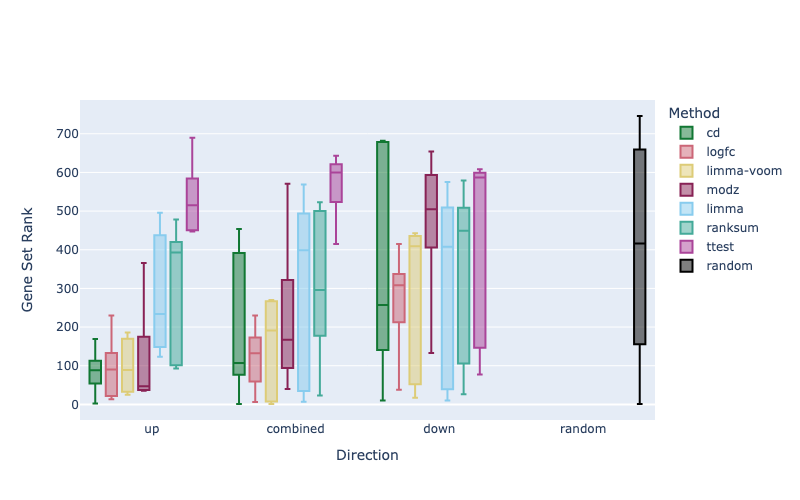

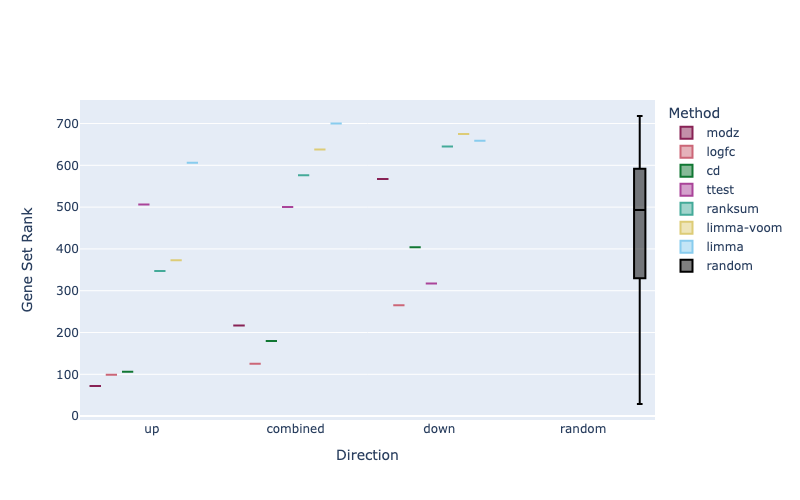

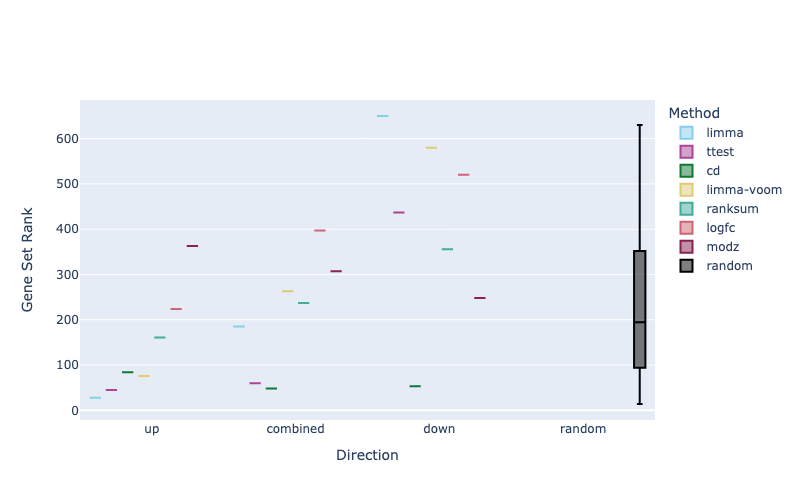

In [52]:
# with ChEA manual libraries
method_color_map = {
    'random': '#000000',
    'cd': '#117733',
    'limma': '#88CCEE',
    'limma-voom': '#DDCC77',
    'fc': '#CC6677',
    'ttest': '#AA4499',
    'ranksum': '#44AA99',
    'modz': '#882255'
}
for tf in full_df['TF'].unique():
    sub_df = full_df[full_df['TF'] == tf]
    sub_df = sub_df[sub_df['Cell'] == 'A375']
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'Wistar' not in x)]
    order = sub_df.groupby('Method_Direction').mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
    sub_df['Method'] = pd.Categorical(sub_df['Method'], order)
    sub_df['Direction'] = pd.Categorical(sub_df['Direction'], ['up', 'combined', 'down'])
    sub_df = sub_df.sort_values(by=['Direction', 'Method'])

    fig1 = go.Figure()
    for method in sub_df['Method'].unique():
        m_df = sub_df[sub_df['Method'] == method]
        fig1.add_trace(
            go.Box(
                x=m_df[m_df['Method'] == method]['Direction'],
                y=m_df[m_df['Method'] == method]['Rank'],
                name=method.replace('fc', 'logfc'), 
                marker_color=method_color_map[method]
            )
        )
    sub_rand_df = rand_df[rand_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            x=sub_rand_df['Method'],
            y=sub_rand_df['Rank'],
            name='random',
            marker_color='black'
        )
    )
    fig1.update_layout(
        width=800,
        boxmode='group',
        boxgap=0.1,
        xaxis={
            'title': {'text': 'Direction'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Rank'}
        },
        legend_title_text='Method'
    )

    fig1.show("png")
    if tf == 'NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/3D_300dpi.png', scale=(800/300))

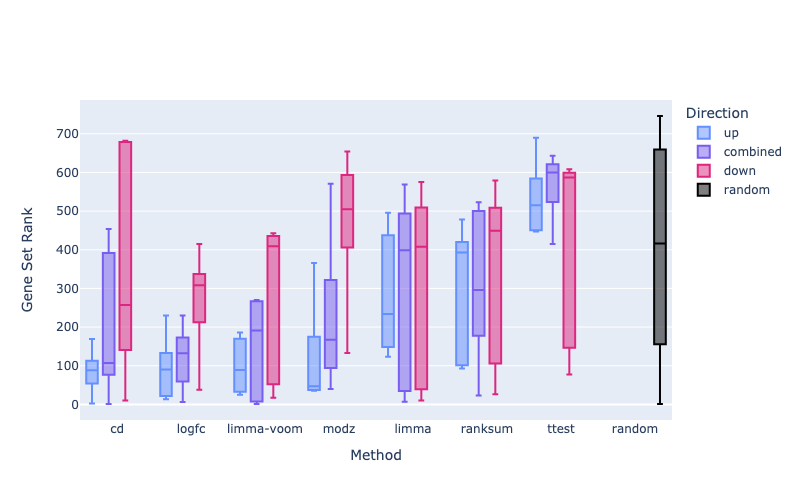

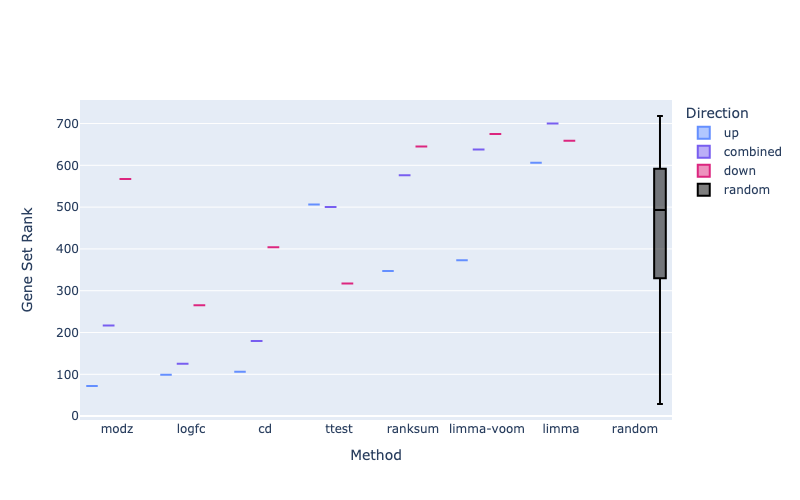

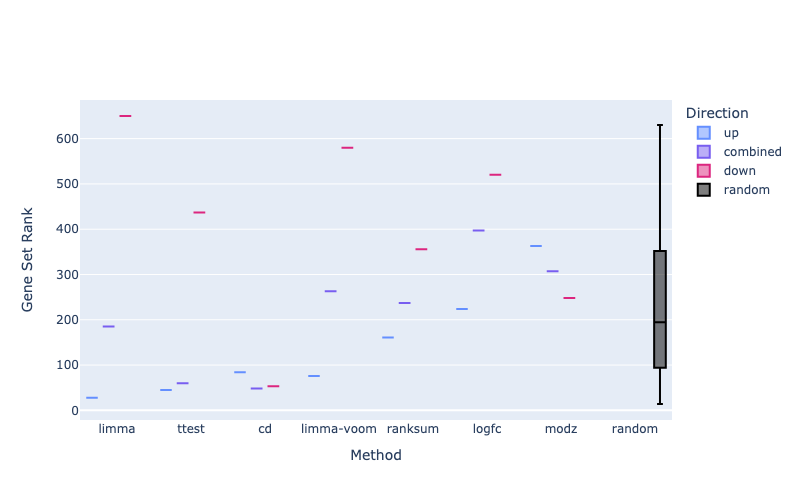

In [50]:
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
for tf in full_df['TF'].unique():
    fig1 = go.Figure()
    sub_df = full_df[full_df['TF'] == tf]
    sub_df = sub_df[sub_df['Cell'] == 'A375']
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'Wistar' not in x)]
    order = sub_df.groupby(['Method_Direction']).mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
    sub_df['Method'] = pd.Categorical(sub_df['Method'], order)
    sub_df['Method'] = sub_df['Method'].apply(lambda x: x.replace('fc', 'logfc'))
    sub_df = sub_df.sort_values(by=['Method'])
    for d in ['up', 'combined', 'down']:
        d_df = sub_df[sub_df['Direction'] == d]
        fig1.add_trace(
            go.Box(
                x=d_df['Method'],
                y=d_df['Rank'],
                name=d, 
                marker_color=method_color_map[d]
            )
        )
    sub_rand_df = rand_df[rand_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            x=sub_rand_df['Method'],
            y=sub_rand_df['Rank'],
            name='random',
            marker_color='black'
        )
    )
    fig1.update_layout(
        width=800,
        boxmode='group',
        boxgap=0.1,
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Rank'}
        },
        legend_title_text="Direction"
    )
    fig1.show("png")
    if tf=='NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/3C_300dpi.png', scale=(800/300))

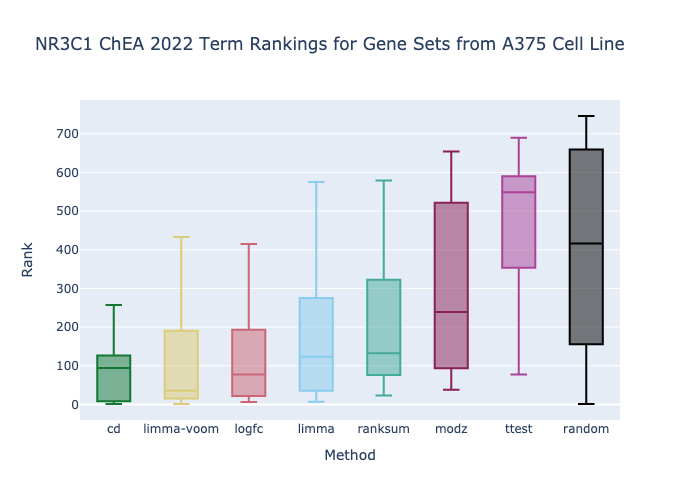

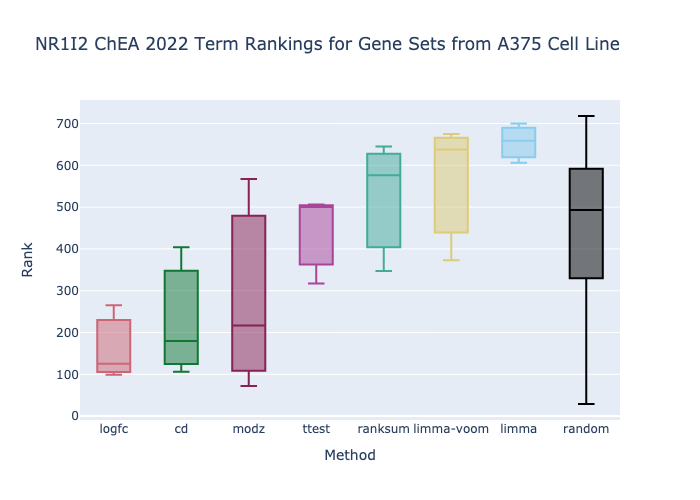

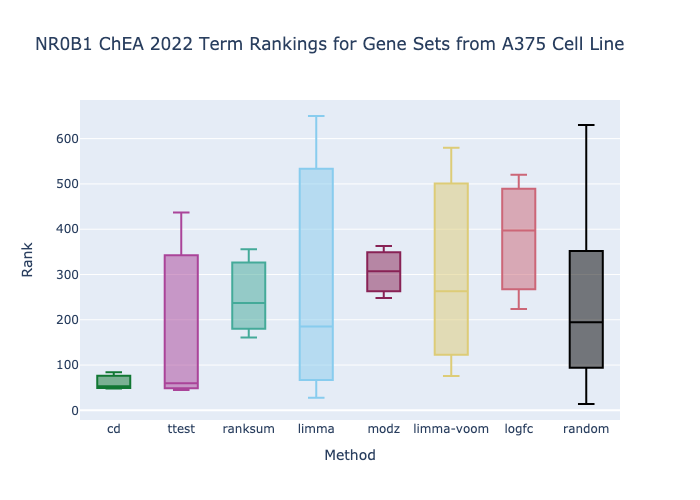

In [49]:
method_color_map = {
    'random': '#000000',
    'cd': '#117733',
    'limma': '#88CCEE',
    'limma-voom': '#DDCC77',
    'fc': '#CC6677',
    'ttest': '#AA4499',
    'ranksum': '#44AA99',
    'modz': '#882255'
}

for tf in full_df['TF'].unique():
    sub_df = full_df[full_df['TF'] == tf]
    sub_df = sub_df[sub_df['Cell'] == 'A375']
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'Wistar' not in x)]
    fig1 = go.Figure()
    for gs in sub_df.groupby(['Method']).mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Method']==gs]['Rank'].tolist(),
                name=gs.replace('fc', 'logfc'), 
                marker_color=method_color_map[gs]
            )
        )
    sub_rand_df = rand_chea2022_df[rand_chea2022_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            y=sub_rand_df['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"{tf} ChEA 2022 Term Rankings for Gene Sets from A375 Cell Line",
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")
    if tf=='NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/3B_300dpi.png', scale=(800/300))

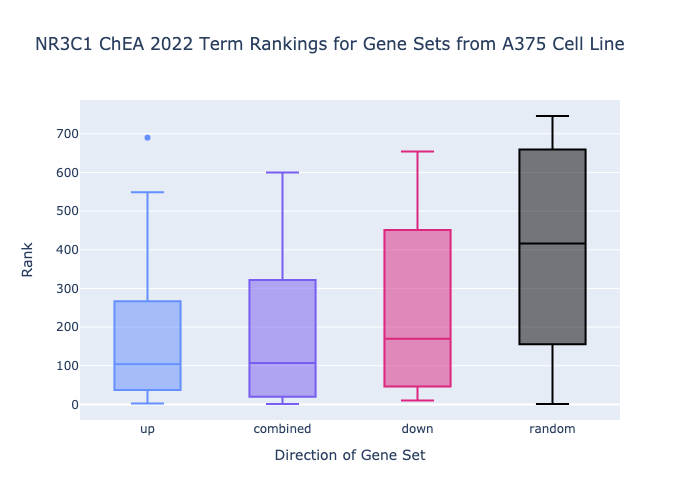

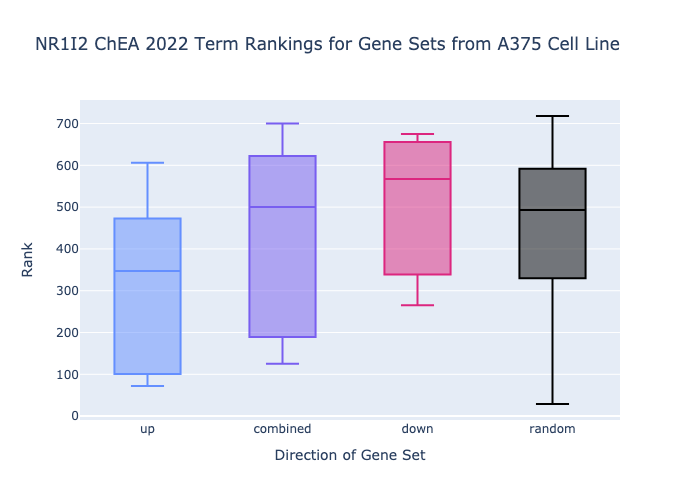

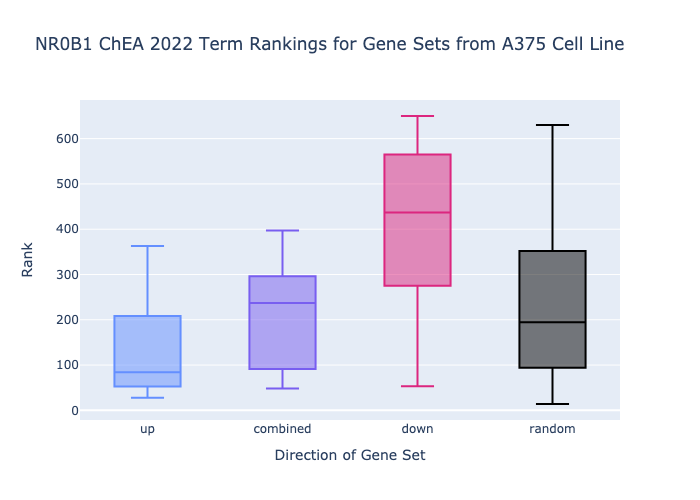

In [45]:
# with ChEA manual libraries
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
for tf in full_df['TF'].unique():
    sub_df = full_df[full_df['TF'] == tf]
    sub_df = sub_df[sub_df['Cell'] == 'A375']
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    fig1 = go.Figure()
    for gs in sub_df.groupby(['Direction']).mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Direction']==gs]['Rank'].tolist(),
                name=gs,
                marker_color=method_color_map[gs]
            )
        )
    sub_rand_df = rand_chea2022_df[rand_chea2022_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            y=sub_rand_df['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"{tf} ChEA 2022 Term Rankings for Gene Sets from A375 Cell Line",
        xaxis={
            'title': {'text': 'Direction of Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")
    if tf=='NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/3A_300dpi.png', scale=(800/300))

## Bridge plots

In [54]:
chea2022_genesets = {
    t: chea2022[t] for t in dex_chea2022_df['Term'].unique() if ('MLEC' not in t and 'Wistar' not in t)
}

In [53]:
bridge_color_map = {
    'random': '#000000',
    'cd': '#117733',
    'limma': '#88CCEE',
    'limma-voom': '#DDCC77',
    'fc': '#CC6677',
    'ttest': '#AA4499',
    'ranksum': '#44AA99',
    'modz': '#882255'
}

In [74]:
def geneSetBridgePlot(gs, method):
    y = [] 
    for col in all_signatures[f"{method}_all"].columns:
        if method in ['fc', 'cd', 'modz']:
            sig = batch_signatures[method][col]['Significance'].sort_values(ascending=False)
        else:
            sig = batch_signatures[method][col]['Significance'].sort_values(ascending=True)
        select = pd.Series(
            [x.upper() in gs for x in sig.index.tolist()]
        )
        _, y_temp = bridge_plot(select)
        y.append(y_temp)
    y_mean = np.mean(np.array(y), axis=0)

    return y_mean

def methodBridgePlot(gsdict, tf, method):
    y = []
    for gs in gsdict.keys(): 
        if tf not in gs:
            continue
        y_temp = geneSetBridgePlot(gsdict[gs], method)
        y.append(y_temp)

    if len(y) == 0:
        return y
    else:
        y_mean = np.mean(np.array(y), axis=0)
        return y_mean

def randomBridgePlot(gsdict, tf): 
    y = []
    for gs in gsdict.keys(): 
        if tf not in gs: 
            continue
        y_gs = []
        for _ in range(10):
            rand_sig = sample(
                combined_expr_df.index.tolist(), 
                combined_expr_df.shape[0]
            )
            select = pd.Series([
                x.upper() in gsdict[gs] for x in rand_sig
            ])
            _, y_temp = bridge_plot(select)
            y_gs.append(y_temp)
        y.append(np.mean(np.array(y_gs), axis=0))
    if len(y) == 0:
        return y
    else:
        y_mean = np.mean(np.array(y), axis=0)
        return y_mean

def tfBridgePlot(tf, lib_genesets, libnames, leading_edge = False): 
    if leading_edge:
        fig = plt.figure(figsize=(7,5))
    else:
        fig = plt.figure(figsize=(7,5))
    for method in batch_signatures.keys(): 
        x = np.arange(all_signatures[f"{method}_all"].shape[0] + 1)
        y = []
        for lg in lib_genesets:
            y1 = methodBridgePlot(lg, tf, method)
            if len(y1) != 0:
                y.append(y1)
        y_mean = np.mean(np.array(y), axis=0)
        if leading_edge:
            x_mean = x/len(x)
            x_mean = x_mean[x_mean < 0.02]
            plt.plot(x_mean, y_mean[:len(x_mean)], label=method.split('_')[0], color=bridge_color_map[method.split('_')[0]])
        else:
            plt.plot(x/len(x), y_mean, label=method.split('_')[0], color=bridge_color_map[method.split('_')[0]])
    rand_x = np.arange(all_signatures[f"{method}_all"].shape[0] + 1)
    rand_y = []
    for lg in lib_genesets:
        rand_y1 = randomBridgePlot(lg, tf)
        if len(rand_y1) != 0: 
            rand_y.append(rand_y1)
    rand_y_mean = np.mean(np.array(rand_y), axis=0)
    if leading_edge:
        rand_x_mean = rand_x/len(rand_x)
        rand_x_mean = rand_x_mean[rand_x_mean < 0.02]
        plt.plot(rand_x_mean, rand_y_mean[:len(rand_x_mean)], label='random', color='gray')
    else:
        plt.plot(rand_x/len(rand_x), rand_y_mean, label='random', color='gray')

    plt.axhline(y=0, color='black', linestyle='dashed')
    if leading_edge:
        plt.legend(bbox_to_anchor=(1,1))
    else:
        plt.legend(bbox_to_anchor=(1, 1))
    locs, labels = plt.xticks()  # Get the current locations and labels.
    if leading_edge:
        plt.xticks(np.arange(0, 0.02, step=0.005))
    plt.xlabel('Rank')
    plt.ylabel('D(r) - r')
    # plt.title(f"{tf} Target Gene Rankings for L1000 Dex Perturbation Signatures\nLibraries: {', '.join(libnames)}")
    plt.show()
    if tf == 'NR3C1': 
        if leading_edge:
            fig.savefig('../../publicationfigs/Figure3F.png', format='png', dpi=300, bbox_inches='tight')
        else:
            fig.savefig('../../publicationfigs/Figure3E.png', format='png', dpi=300, bbox_inches='tight')

Ranking by absolute expression value

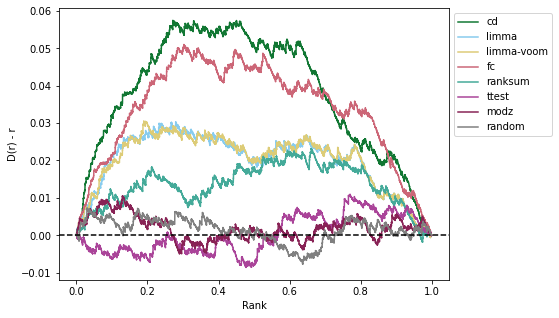

In [75]:
tfBridgePlot('NR3C1', [chea2022], ['ChEA 2022'])

<Figure size 432x288 with 0 Axes>

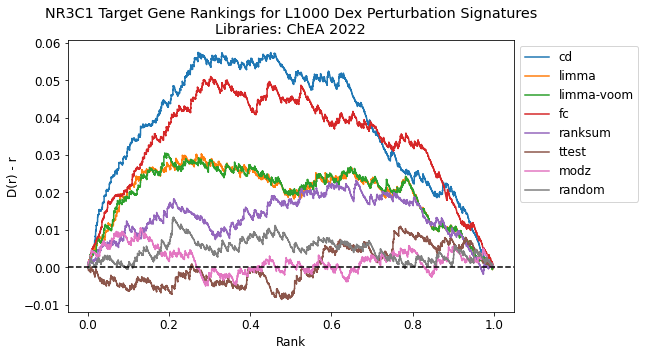

In [674]:
tfBridgePlot('NR3C1', [chea2022], ['ChEA 2022'])

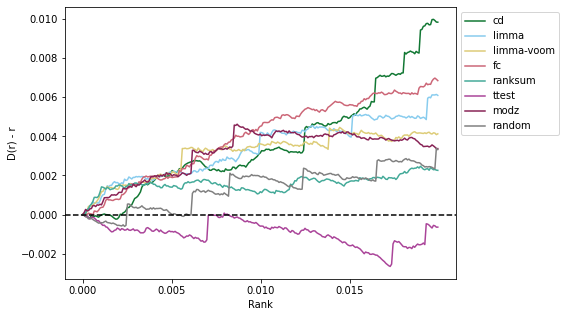

In [76]:
tfBridgePlot('NR3C1', [chea2022], ['ChEA 2022'], True)

<Figure size 432x288 with 0 Axes>

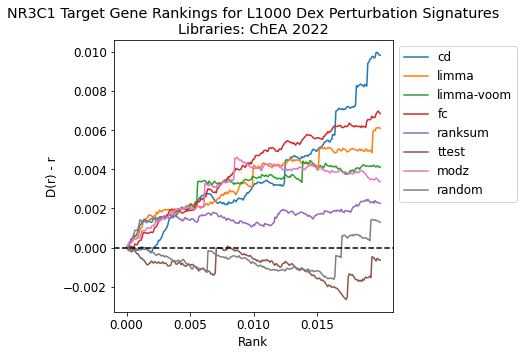

In [675]:
tfBridgePlot('NR3C1', [chea2022], ['ChEA 2022'], True)

## Signature similarity

In [104]:
rank_comparisons = {
  b: pd.concat([
    all_signatures[method][b].rename(method.split('_')[0]).rank() for method in all_signatures.keys()
  ], axis=1).dropna(axis=0).sort_index(axis=1)
for b in batches}

expr_comparisons = {
  b: pd.concat([
    all_signatures[method][b].rename(method.split('_')[0]) for method in all_signatures.keys()
  ], axis=1).dropna(axis=0).sort_index(axis=1)
for b in batches}

method_cols = rank_comparisons[list(batches)[0]].columns

In [107]:
sns.set(font_scale=1.2)

### Correlation of signature expression values

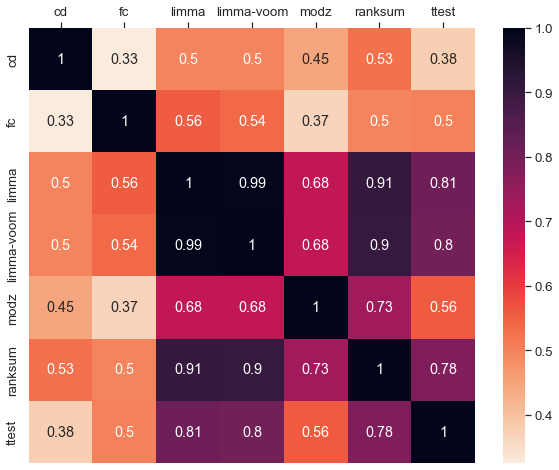

In [108]:
expr_correlations = {
  b: 1 - pairwise_distances(m.T, metric='cosine') for b,m in expr_comparisons.items()
}
for _,m in expr_correlations.items():
  np.fill_diagonal(m, 1)

expr_mean_correlations = np.zeros(shape=expr_correlations[list(batches)[0]].shape)
for i in range(expr_mean_correlations.shape[0]):
  for j in range(expr_mean_correlations.shape[1]): 
    expr_mean_correlations[i,j] = np.mean([m[i,j] for _,m in expr_correlations.items()])

hm, hm_ax = plt.subplots(figsize=(10,8))
sns.heatmap(pd.DataFrame(
  expr_mean_correlations, index=method_cols, columns=method_cols
), cmap=sns.cm.rocket_r, annot=True)
hm_ax.xaxis.tick_top()

### Correlation of signature gene ranks

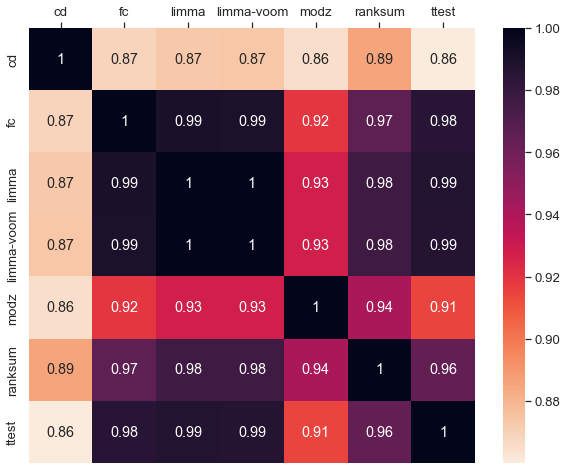

In [109]:
rank_correlations = {
  b: 1 - pairwise_distances(m.T, metric='cosine') for b,m in rank_comparisons.items()
}
for _,m in rank_correlations.items():
  np.fill_diagonal(m, 1)

rank_mean_correlations = np.zeros(shape=rank_correlations[list(batches)[0]].shape)
for i in range(rank_mean_correlations.shape[0]):
  for j in range(rank_mean_correlations.shape[1]): 
    rank_mean_correlations[i,j] = np.mean([m[i,j] for _,m in rank_correlations.items()])

hm, hm_ax = plt.subplots(figsize=(10,8))
sns.heatmap(pd.DataFrame(
  rank_mean_correlations, index=method_cols, columns=method_cols
), cmap=sns.cm.rocket_r, annot=True)
hm_ax.xaxis.tick_top()